In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import xgboost as xgb
from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from mlxtend.feature_selection import SequentialFeatureSelector

import os
from datetime import datetime
from github import Github
from dotenv import load_dotenv
from IPython.display import clear_output

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 100)
plt.style.use('ggplot')

load_dotenv()
GITHUB_API_KEY = os.environ['GITHUB_API_KEY']

In [2]:
g = Github(GITHUB_API_KEY)
repo = g.get_user().get_repo('Estate-Prague')
contents = repo.get_contents("data-rental")

In [3]:
df_concated = pd.read_csv(contents[0].download_url)

for file in contents[:41]:
    clear_output(wait=True)
    print(f'Processing file: {file.name}')
    url = file.download_url
    df_single = pd.read_csv(url)
    df_concated = pd.concat([df_concated,df_single],axis=0,ignore_index=True)

df = df_concated.drop_duplicates(subset=['Listing ID','Floor Space'], keep='first')
df.to_csv('df_.csv',index=False)

Processing file: Prague-2022-02-25.csv


In [9]:
def missing_data(df):
    return 100*df.isnull().sum()/len(df)

def droping_data(df):
    
    df = df.drop('Listing ID',axis=1) 
    df = df.drop('New building',axis=1)
    df = df.drop('Front garden',axis=1)
    df = df.drop('Developer name',axis=1)
    df = df.drop('Project name',axis=1)
    df = df.drop('Kód jednotky',axis=1)
    df = df.drop('Administration fee',axis=1)
    df = df.drop('Ownership Type',axis=1)
    df = df.drop('Refundable security deposit',axis=1)
    df = df.drop('Available from',axis=1)
    df = df.drop('Playground',axis=1)
    df = df.drop('Post office',axis=1)
    df = df.drop('Bank',axis=1)
    df = df.drop('Pharmacy',axis=1)
    df = df.dropna(axis=0,subset=['Floor Space'])
    df = df[df['Layout']!='Other']
    try:
        df = df.drop('Investment Advisor',axis=1)
    except:
        pass
    
    return df

def district_extract(string):
    return string.split('Prague - ')[1]

def rare_district_renaming(district):
    if district not in df['District'].value_counts()[:25].index:
        return 'Other'
    else:
        return district

def feature_engineering(df):
    
    df['Price'] = pd.to_numeric(df['Price'].str.replace('CZK ','').str.replace(',',''))
    df['Fees'] = pd.to_numeric(df['Fees'].str.replace('CZK ','').str.replace(',',''))
    df['Floor Space'] = pd.to_numeric(df['Floor Space'].str.replace(',','').str.replace(' m²',''))
    df['District'] = df['District'].apply(district_extract)
    df['District'] = df['District'].apply(rare_district_renaming)
    
    if df['Public transport stop'].dtype == 'O':
        df['Public transport stop'] = pd.to_numeric(df['Public transport stop'].str.replace(',',''))
    if df['Shop'].dtype == 'O':
        df['Shop'] = pd.to_numeric(df['Shop'].str.replace(',',''))
    if df['Restaurant'].dtype == 'O':
        df['Restaurant'] = pd.to_numeric(df['Restaurant'].str.replace(',',''))
    if df['School'].dtype == 'O':
        df['School'] = pd.to_numeric(df['School'].str.replace(',',''))
    if df['Kindergarten'].dtype == 'O':
        df['Kindergarten'] = pd.to_numeric(df['Kindergarten'].str.replace(',',''))
    if df['Sports field'].dtype == 'O':
        df['Sports field'] = pd.to_numeric(df['Sports field'].str.replace(',',''))
    
    return df

def filtering_outliers(df):
    
    df = df[df['Floor Space']>10]
    df = df[df['Floor Space']<125]
    df = df[df['Price']>3000]
    df = df[df['Price']<30000]
    df = df[df['Fees']<10000]
    df.loc[df['Fees']<400,'Fees'] = np.nan
    
    return df

def fixing_fees(df):
    
    df['ratio'] = df['Price']/df['Fees']
    df.loc[(df['ratio'].between(2.95,3.05)) & (df['Price']>10000),'Fees'] = np.nan
    df = df.drop('ratio',axis=1)
    fees_df = df[['Floor Space','Fees']]
    fees_df = fees_df.dropna()
    fees_coeff = np.polyfit(fees_df['Floor Space'],fees_df['Fees'],1)
    df['Fees'] = df['Fees'].fillna(fees_coeff[0]*df['Floor Space'] + fees_coeff[1])
    
    return df

def total_cost(df):
    
    df['Total price'] = df['Price']+df['Fees']
    df = df.drop('Price',axis=1) 
    df = df.drop('Fees',axis=1) 
    
    return df

def mapping_data(df):
    
    df['Layout'] = df['Layout'].map({
                                        'Small studio':0.5, 
                                        'Studio':0.75,
                                        '1 bedroom with open-plan kitchen':1.5,
                                        '1 bedroom':1,
                                        '2 bedroom with open-plan kitchen':2.5,
                                        '2 bedroom':2,
                                        '3 bedroom with open-plan kitchen':3.5,
                                        '3 bedroom':3,
                                        '4 bedroom with open-plan kitchen':4.5,
                                        '4 bedroom':4,
                                        '5 bedroom with open-plan kitchen':5.5,   
                                        '5 bedroom':5,
                                        '6 bedroom with open-plan kitchen':6.5,
                                        '6 bedroom':6
                                                                                })
    
    
    df['PENB'] = df['PENB'].map({'G':7,'F':6,'E':5,'D':4,'C':3,'B':2,'A':1})
    
    df['Balcony'] = df['Balcony'].map({'Yes':1,'No':0})
    df['Terrace'] = df['Terrace'].map({'Yes':1,'No':0})
    df['Cellar'] = df['Cellar'].map({'Yes':1,'No':0})
    df['Loggia'] = df['Loggia'].map({'Yes':1,'No':0})
    df['Parking'] = df['Parking'].map({'Yes':1,'No':0})
    df['Lift'] = df['Lift'].map({'Yes':1,'No':0})
    df['Garage'] = df['Garage'].map({'Yes':1,'No':0})
    
    return df

def replacing_categories(df):
    
    df['Condition'] = df['Condition'].replace('In need of repair',np.nan)
    df['Condition'] = df['Condition'].replace('Development project','New build')
    df['Building Type'] = df['Building Type'].replace('Wooden building',np.nan)
    df['Total number of floors'] = df['Total number of floors'].replace('Raised ground floor','Ground floor')
    df['Heating'] = df['Heating'].replace('Geothermal heat pump',np.nan)
    df.loc[df['Floor']>10,'Floor'] = 10
    df['Age'] = df['Age'].replace('over 50 years years','over 30 years years')
    df['Age'] = df['Age'].replace('30 to 50 years years','over 30 years years')
    df['Renovation'] = df['Renovation'].replace('Exterior',np.nan)
    df['Renovation'] = df['Renovation'].replace('Bathroom unit',np.nan)
    
    return df

def missing_values(df):
    
    df['Design'] = df['Design'].fillna('Standard materials and solutions')
    df['Floor'] = df['Floor'].fillna(1)
    df['Public transport stop'] = df['Public transport stop'].fillna(df['Public transport stop'].median())
    df['Shop'] = df['Shop'].fillna(df['Shop'].median())
    df['Restaurant'] = df['Restaurant'].fillna(df['Restaurant'].median())
    df['School'] = df['School'].fillna(df['School'].median())
    df['Kindergarten'] = df['Kindergarten'].fillna(df['Kindergarten'].median())
    df['Sports field'] = df['Sports field'].fillna(df['Sports field'].median())
    df['PENB'] = df['PENB'].fillna(np.round(df.groupby('Building Type')['PENB'].transform('mean'),0))
    df['PENB'] = df['PENB'].fillna(5)
        
    return df

In [3]:
df = pd.read_csv('df_.csv')

In [5]:
df = droping_data(df)
df = feature_engineering(df)
df = filtering_outliers(df)
df = fixing_fees(df)
df = total_cost(df)
df = mapping_data(df)
df = replacing_categories(df)
df = missing_values(df)

In [6]:
y = df['Total price']
X = df.drop('Total price',axis=1)
X = pd.get_dummies(X,drop_first=False)
X.columns = X.columns.str.replace(' ','_')
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=101,shuffle=True)

In [7]:
def evaluation(model,X_train,X_test,y_train,y_test):
    y_pred_train = model.predict(X_train)
    y_pred = model.predict(X_test)

    MAE = mean_absolute_error(y_test,y_pred)
    ERR = np.mean(np.abs(y_test-y_pred)*100/y_test)
    MAE2 = mean_absolute_error(y_train,y_pred_train)
    ERR2 = np.mean(np.abs(y_train-y_pred_train)*100/y_train)

    print(f'Mean absolute error (train):\t{np.round(MAE2)} CZK \t({np.round(ERR2,1)}%)')
    print(f'Mean absolute error (test):\t{np.round(MAE)} CZK \t({np.round(ERR,1)}%)')

### XGBoost - All features

In [8]:
xgb0 = xgb.XGBRegressor()
xgb0.fit(X_train,y_train)
evaluation(xgb0,X_train,X_test,y_train,y_test)

Mean absolute error (train):	541.0 CZK 	(3.2%)
Mean absolute error (test):	1837.0 CZK 	(10.6%)


### XGBoost - All features - Hyperparameters tuned

In [16]:
grid_paramters = { 'n_estimators': [250],
                   'eta': [0.15],
                   'gamma': [0.5],
                   'max_depth':[2],
                   'subsample': [0.8,0.9,0.95],
                   'colsample_bytree': [0.8,0.9,0.95],
                   'colsample_bylevel': [0.8,0.9,0.95],
                   'colsample_bynode' : [0.8,0.9,0.95],
                   'min_child_weight': [0,2.5,5,7.5,10],
                   'reg_lambda': [0,2.5,5,9,15,30],
                   'reg_alpha': [1,10,25,50,100,150,200]
                }

In [17]:
xgb1 = xgb.XGBRegressor(early_stopping_rounds=10, eval_metric='mae', verbosity=0)

In [28]:
xgb1_grid = RandomizedSearchCV( estimator = xgb1,
                                param_distributions = grid_paramters,
                                scoring = 'neg_mean_absolute_error',
                                n_iter = 250,
                                cv = 5,
                                verbose = 0,
                                n_jobs = -1)
xgb1_grid.fit(X_train,y_train,eval_set=[(X_test, y_test),(X_train,y_train)],verbose=False)
print("Evaluation:")
evaluation(xgb1_grid,X_train,X_test,y_train,y_test)

Evaluation:
Mean absolute error (train):	1745.0 CZK 	(10.1%)
Mean absolute error (test):	1868.0 CZK 	(10.8%)


In [29]:
best_hyperp_1 = xgb1_grid.best_params_
%store best_hyperp_1

Stored 'best_hyperp_1' (dict)


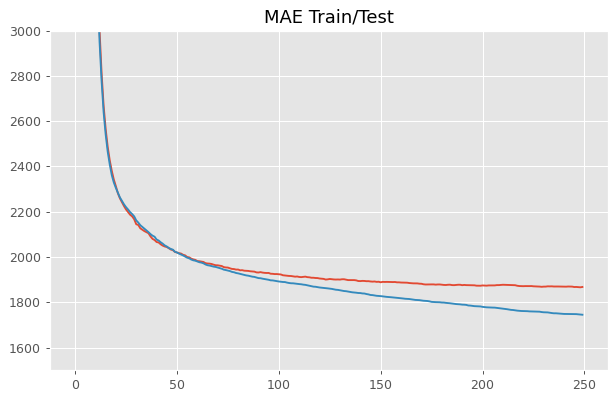

In [30]:
results = xgb1_grid.best_estimator_.evals_result()
epochs = len(results['validation_0']['mae'])
x_axis = range(0, epochs)

plt.figure(figsize=(8,5),dpi=90)
sns.lineplot(x=x_axis,y=results['validation_0']['mae']).set(title='MAE Train/Test')
sns.lineplot(x=x_axis,y=results['validation_1']['mae'])
plt.ylim(1500,3000);

### XGBoost - Feature selection - Sequential Feature Selection

In [162]:
xgb2 = xgb.XGBRegressor(**xgb1.best_params_)
sfs = SequentialFeatureSelector(xgb2,
                                k_features=6,
                                forward=False,
                                floating=False,
                                scoring = 'neg_mean_absolute_error',
                                cv = 3)
sfs.fit(X_train, y_train)
clear_output(wait=True)
scores = pd.DataFrame(sfs.subsets_).transpose()['avg_score'].apply(float)

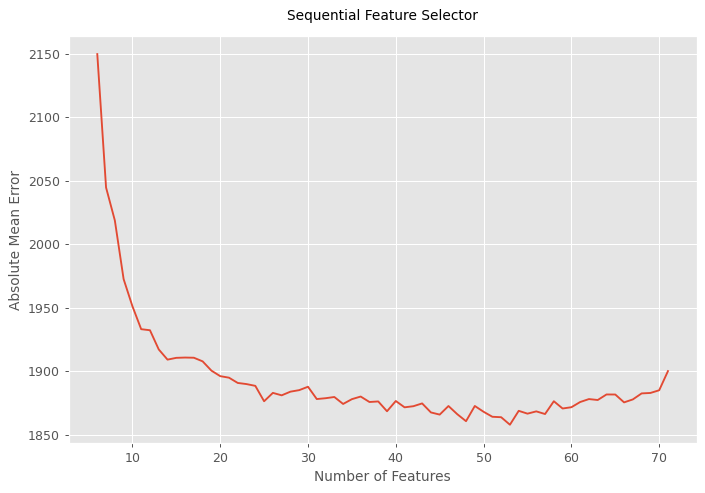

In [163]:
plt.figure(figsize=(9,6),dpi=90)
sns.lineplot(x=scores.index,y=-scores.values)
plt.xlabel("Number of Features", fontsize= 11)
plt.ylabel("Absolute Mean Error", fontsize= 11)
plt.title("Sequential Feature Selector", fontsize= 11, y=1.02);

In [168]:
sfs_selected_features = list(sfs.subsets_[50]['feature_names'])

In [169]:
xgb3 = RandomizedSearchCV(estimator = xgb.XGBRegressor(),
                          param_distributions = grid_paramters,
                          scoring = 'neg_mean_absolute_error',
                          n_iter = 500,
                          cv = 5,
                          verbose=1,
                          n_jobs = -1)
xgb3.fit(X_train[sfs_selected_features],y_train)
clear_output(wait=True)
evaluation(xgb3,X_train[sfs_selected_features],X_test[sfs_selected_features],y_train,y_test)

Mean absolute error (train):	1145.0 CZK 	(6.7%)
Mean absolute error (test):	1834.0 CZK 	(10.6%)


### XGBoost - Feature Selection - My own choice

In [39]:
grid_paramters = { 'n_estimators': [1000],
                   'eta': [0.3],
                   'gamma': uniform(0.01,5),
                   'max_depth':[3],
                   'subsample': [0.8,0.9,0.95,0.99],
                   'colsample_bytree': [0.7,0.8,0.9,0.95,0.99],
                   'colsample_bylevel': [0.7,0.8,0.9,0.95,0.99],
                   'colsample_bynode' : [0.7,0.8,0.9,0.95,0.99],
                   'min_child_weight': uniform(1,10),
                   'reg_lambda': uniform(0,200),
                   'reg_alpha': uniform(0,750)}

In [12]:
my_selected_features = ['Latitude','Longitude','Layout','Floor Space','Balcony','Terrace','Cellar','Lift','Garage',
                     'Furnishing and Fittings','Condition','Building Type','Design','Heating']

y = df['Total price']
X = df.drop('Total price',axis=1)
X = X[my_selected_features]
X = pd.get_dummies(X,drop_first=False)
X.columns = X.columns.str.replace(' ','_')
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=101,shuffle=True)

In [40]:
xgb_regressor = xgb.XGBRegressor(early_stopping_rounds=10, eval_metric='mae')


xgb4 = RandomizedSearchCV(estimator = xgb_regressor,
                          param_distributions = grid_paramters,
                          scoring = 'neg_mean_absolute_error',
                          n_iter = 10,
                          cv = 5,
                          verbose=1,
                          n_jobs = -1)
xgb4.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)], verbose=False)

clear_output(wait=True)
evaluation(xgb4,X_train,X_test,y_train,y_test)

Mean absolute error (train):	1344.0 CZK 	(7.8%)
Mean absolute error (test):	1880.0 CZK 	(10.9%)


(1000.0, 3000.0)

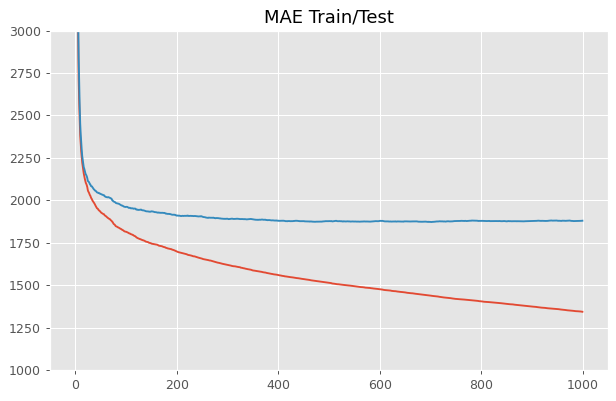

In [42]:
results = xgb4.best_estimator_.evals_result()
epochs = len(results['validation_0']['mae'])
x_axis = range(0, epochs)

plt.figure(figsize=(8,5),dpi=90)
sns.lineplot(x=x_axis,y=results['validation_0']['mae']).set(title='MAE Train/Test')
sns.lineplot(x=x_axis,y=results['validation_1']['mae'])
plt.ylim(1000,3000)

In [85]:
xgb4.best_params_

NameError: name 'xgb4' is not defined

## Boruta Feature Selection

In [11]:
from BorutaShap import BorutaShap

xgb_reg = xgb.XGBRegressor(eval_metric='mae', n_estimators=250, eta=0.15, max_depth=2)
Feature_Selector = BorutaShap(model=xgb_reg, importance_measure = 'shap', percentile=80, pvalue=0.05, classification=False)
Feature_Selector.fit(X=X_train, y=y_train, n_trials=1000, sample=False, verbose=True)

100%|██████████| 1000/1000 [08:02<00:00,  2.07it/s]

29 attributes confirmed important: ['District_Staré_Město', 'Longitude', 'Cellar', 'Terrace', 'Building_Type_Brick_building', 'Building_Type_Prefab_concrete_building', 'Building_Type_Low-energy_building', 'Kindergarten', 'Heating_Other', 'Furnishing_and_Fittings_Unfurnished', 'Floor_Space', 'Design_Premium_materials_and_solutions', 'Furnishing_and_Fittings_Furnished', 'Layout', 'School', 'District_Vinohrady', 'Latitude', 'Condition_Good', 'Heating_District_heating', 'Shop', 'Condition_Excellent', 'Condition_New_build', 'Garage', 'Restaurant', 'Floor', 'Sports_field', 'Lift', 'Public_transport_stop', 'District_Karlín']
42 attributes confirmed unimportant: ['District_Modřany', 'District_Stodůlky', 'District_Břevnov', 'Age_1_to_10_years_years', 'District_Michle', 'Total_number_of_floors_Middle_floor', 'Furnishing_and_Fittings_Partially_furnished', 'District_Vysočany', 'Total_number_of_floors_Top_floor', 'District_Krč', 'District_Kobylisy', 'Heating_Gas_boiler', 'Heating_Electric_boiler', 

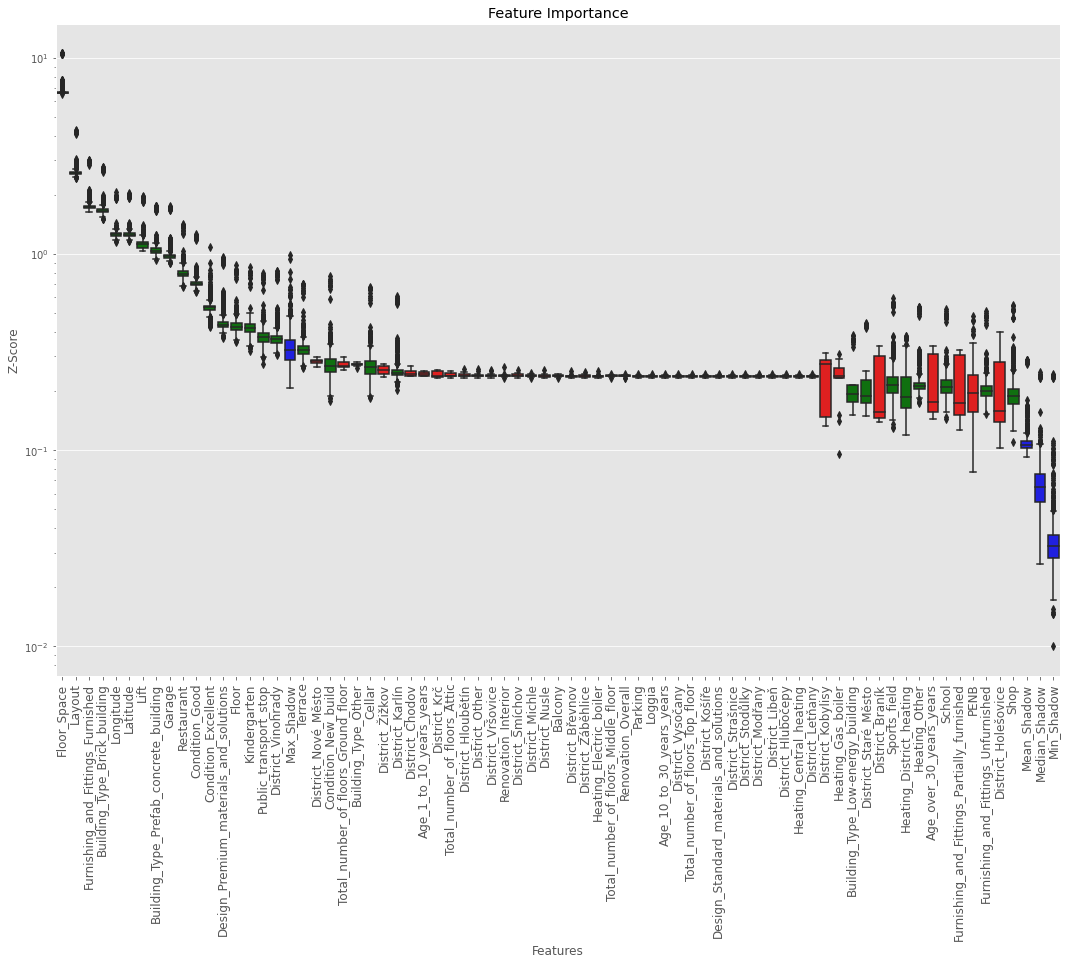

In [12]:
Feature_Selector.plot(X_size=12, figsize=(18,12),y_scale='log', which_features='all')

In [13]:
subset = list(Feature_Selector.Subset().columns)
# %store subset

Stored 'subset' (list)


In [31]:
grid_paramters = { 'n_estimators': [250],
                   'eta': [0.15],
                   'gamma': [0.5],
                   'max_depth':[2],
                   'subsample': [0.8,0.9,0.95],
                   'colsample_bytree': [0.8,0.9,0.95],
                   'colsample_bylevel': [0.8,0.9,0.95],
                   'colsample_bynode' : [0.8,0.9,0.95],
                   'min_child_weight': [0,2.5,5,7.5,10],
                   'reg_lambda': [0,2.5,5,9,15,30],
                   'reg_alpha': [1,10,25,50,100,150,200]
                }

In [33]:
xgb2 = xgb.XGBRegressor(early_stopping_rounds=10, eval_metric='mae', verbosity=0)
xgb2_grid = RandomizedSearchCV( estimator = xgb2,
                                param_distributions = grid_paramters,
                                scoring = 'neg_mean_absolute_error',
                                n_iter = 250,
                                cv = 5,
                                verbose = 0,
                                n_jobs = -1)
xgb2_grid.fit(X_train[subset],y_train,eval_set=[(X_test[subset], y_test),(X_train[subset],y_train)],verbose=False)
print("Evaluation:")
evaluation(xgb2_grid,X_train[subset],X_test[subset],y_train,y_test)

Evaluation:
Mean absolute error (train):	1753.0 CZK 	(10.2%)
Mean absolute error (test):	1876.0 CZK 	(10.8%)


In [41]:
best_hyperp_2 = xgb2_grid.best_params_
%store best_hyperp_2

Stored 'best_hyperp_2' (dict)


In [15]:
%store -r best_hyperp_2

In [13]:
df = pd.read_csv("df_.csv")
df = droping_data(df)
df = feature_engineering(df)
df = filtering_outliers(df)
df = fixing_fees(df)
df = total_cost(df)
df = mapping_data(df)
df = replacing_categories(df)
df = missing_values(df)

%store -r subset
X_sample = pd.get_dummies(df,drop_first=False)
X_sample.columns = X_sample.columns.str.replace(' ','_')
X_sample = X_sample[subset]

In [38]:
g = Github(GITHUB_API_KEY)
repo = g.get_user().get_repo('Estate-Prague')
contents = repo.get_contents("data-rental")

xs=[]
ys=[]
ys2=[]

for file in contents:
    clear_output(wait=True)
    print(f'Processing file: {file.name}')
    url = file.download_url
    df = pd.read_csv(url)

    df = droping_data(df)
    df = feature_engineering(df)
    df = filtering_outliers(df)
    df = fixing_fees(df)
    df = total_cost(df)
    df = mapping_data(df)
    df = replacing_categories(df)
    df = missing_values(df)

    y = df['Total price']

    X = pd.get_dummies(df,drop_first=False)
    X.columns = X.columns.str.replace(' ','_')
    X = X[subset]

    xgb3 = xgb.XGBRegressor(**best_hyperp_2)
    xgb3.fit(X,y)
    y_sample_predition = xgb3.predict(X_sample)
    size_listing = len(df)
    ys.append(y_sample_predition)
    ys2.append(size_listing)
    xs.append(datetime.strptime(file.name, 'Prague-%Y-%m-%d.csv'))

Processing file: Prague-2022-05-25.csv


In [19]:
price_change = []
for ys_i in ys:
    delta = ((ys_i-ys[0])/ys[0]).mean()*100
    price_change.append(delta)

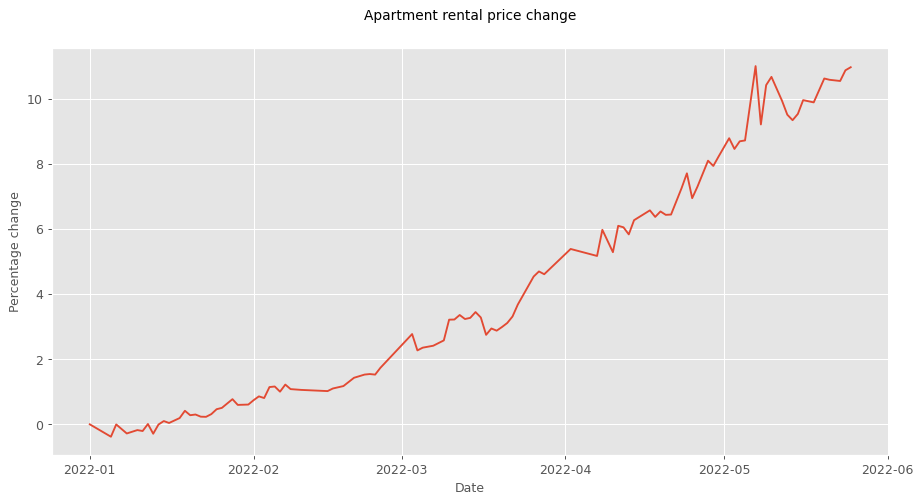

In [22]:
plt.figure(figsize=(12,6),dpi=90)
sns.lineplot(x=xs,y=price_change)
plt.xlabel("Date", fontsize= 10)
plt.ylabel("Percentage change", fontsize= 10)
plt.title("Apartment rental price change", fontsize= 11, y=1.05)
plt.xticks(rotation=0);

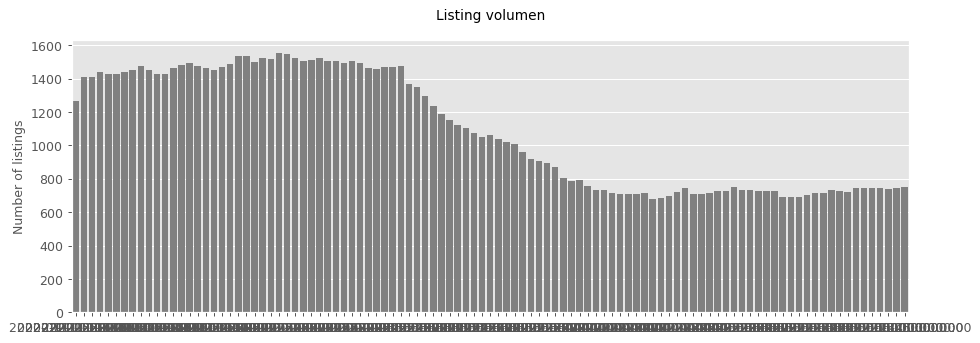

In [37]:
plt.figure(figsize=(12,4),dpi=90)
# sns.lineplot(x=xs,y=ys2,markers=True,marker='o')
sns.barplot(x=xs,y=ys2,color='grey')
plt.ylabel("Number of listings", fontsize= 10)
plt.title("Listing volumen", fontsize= 11, y=1.05)
plt.xticks(rotation=0);

In [35]:
help(sns.barplot)

Help on function barplot in module seaborn.categorical:

barplot(*, x=None, y=None, hue=None, data=None, order=None, hue_order=None, estimator=<function mean at 0x000001C07C7251F0>, ci=95, n_boot=1000, units=None, seed=None, orient=None, color=None, palette=None, saturation=0.75, errcolor='.26', errwidth=None, capsize=None, dodge=True, ax=None, **kwargs)
    Show point estimates and confidence intervals as rectangular bars.
    
    A bar plot represents an estimate of central tendency for a numeric
    variable with the height of each rectangle and provides some indication of
    the uncertainty around that estimate using error bars. Bar plots include 0
    in the quantitative axis range, and they are a good choice when 0 is a
    meaningful value for the quantitative variable, and you want to make
    comparisons against it.
    
    For datasets where 0 is not a meaningful value, a point plot will allow you
    to focus on differences between levels of one or more categorical
    va